In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deliverable 2 for Team 3

### Second Batch of Data

We researched and recorded the gender of the professors who did not manage to be assigned a gender by gender-api for the last deliverable. We scraped the USPTO numbers and their corresponding inventor for ~6000 patents/patent applications from MIT collaboration's website. We performed a search on USPTO's database and acquired the filing dates for ~3000 patents.

### Refined Preliminary Analysis

Since in this deliverable we acquired new data for patents, we only updated and included the preliminary analysis for patents in the next few sections.

### Preprocessing Step

Here we remove USPTO numbers for patent applications (has the format of nn/nnnnnn or 11-12 digits) or in the wrong format

In [4]:
df = pd.read_csv('D:\CS\cs506\project/patents_date.csv')

print('Before processing: ', df.shape)
df_patents = df[~df['USPTO'].str.contains('/')].reset_index()
df_patents['Len_USPTO'] = df_patents['USPTO'].astype(str).apply(len)
df_patents = df_patents[(df_patents['Len_USPTO'] > 6) & (df_patents['Len_USPTO'] < 9)]
print('After processing: ', df_patents.shape)


Before processing:  (5957, 3)
After processing:  (4467, 5)


Currently we are only able to acquire filing dates for ~3000 USPTO numbers from USPTO's database and hence eliminate those not yet found from our analysis.

In [5]:
df_patents_nonan = df_patents.dropna().reset_index()
print('After eliminating nan values: ', df_patents_nonan.shape)
print('Number of unique patents in final selection: ', len(pd.unique(df_patents_nonan['USPTO'])))

After eliminating nan values:  (3779, 6)
Number of unique patents in final selection:  3013


### Key Question 2

Has this disparity changed over time and, if so, in what way?

In [4]:
df_prof = pd.read_csv('D:\CS\cs506\project/MIT_Faculty_deliv2.csv')

Here we match the author's unique ID to our data for the professors to get their gender and department

In [35]:
genders = []
departments = []
for author_id in df_patents_nonan['Author_Id'].astype(str).tolist():
    gender = df_prof['Gender'][df_prof['Id'].astype(str) == author_id].tolist()[0]
    department = df_prof['Department'][df_prof['Id'].astype(str).fillna('') == author_id].tolist()[0]
    genders.append(gender)
    departments.append(department)

df_patents_nonan['Gender'] = genders
df_patents_nonan['Department'] = departments

df_patents_nonan['Gender'] = df_patents_nonan['Gender'].astype(str)
df_patents_nonan['Department'] = df_patents_nonan['Department'].astype(str)

Then we plot the total number of patents and the average number of patents per professor for each gender.

Text(0, 0.5, 'Number of Patents')

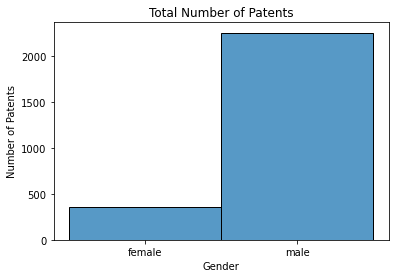

In [6]:
plt.figure()
sns.histplot(data=df_patents_nonan['Gender'])
plt.title('Total Number of Patents')
plt.ylabel('Number of Patents')

Text(0, 0.5, 'Number of Patents')

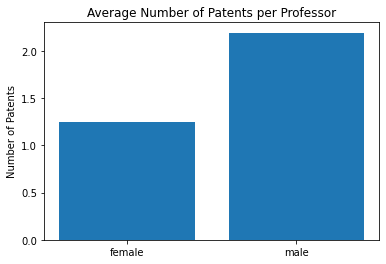

In [7]:
gender_pat = df_patents_nonan['Gender'].value_counts()
gender_prof = df_prof['Gender'].value_counts()

plt.bar([1,0], (gender_pat / gender_prof).to_numpy(), tick_label=['male', 'female'])
plt.title('Average Number of Patents per Professor')
plt.ylabel('Number of Patents')

We see a large disparity in total number of patents between the genders that gets smaller as we account for the number of professors for each gender, which matches our finding from deliverable 1.

Then we examine the disparity in gender across the departments.

In [55]:
# Drop professors without a department
df_patents_department = df_patents_nonan[df_patents_nonan['Department'] != 'nan']

n_patents_department = df_patents_department['Gender'].groupby(df_patents_department['Department']).value_counts().to_frame('N_Patents').reset_index()
n_prof_department = df_prof['Gender'].groupby(df_prof['Department']).value_counts().to_frame('N_Prof').reset_index()

for department in n_patents_department['Department'].unique():
    for gender in ['male', 'female']:
        n_prof = n_prof_department[(n_prof_department['Gender'] == gender) & (n_prof_department['Department'] == department)]['N_Prof']
        ind = n_patents_department[(n_patents_department['Gender'] == gender) & (n_patents_department['Department'] == department)].index

        if n_prof.empty:
            n_patents_department.loc[ind, 'N_Patents_Prof'] = 0

        else:
            n_patent = n_patents_department[(n_patents_department['Gender'] == gender) & (n_patents_department['Department'] == department)]['N_Patents']

            try:
                n_patents_department.loc[ind, 'N_Patents_Prof'] = (n_patent.values / n_prof.values)[0]
            except:
                n_patents_department.loc[ind, 'N_Patents_Prof'] = 0

Text(0, 0.5, 'Average Number of Patents per Professor')

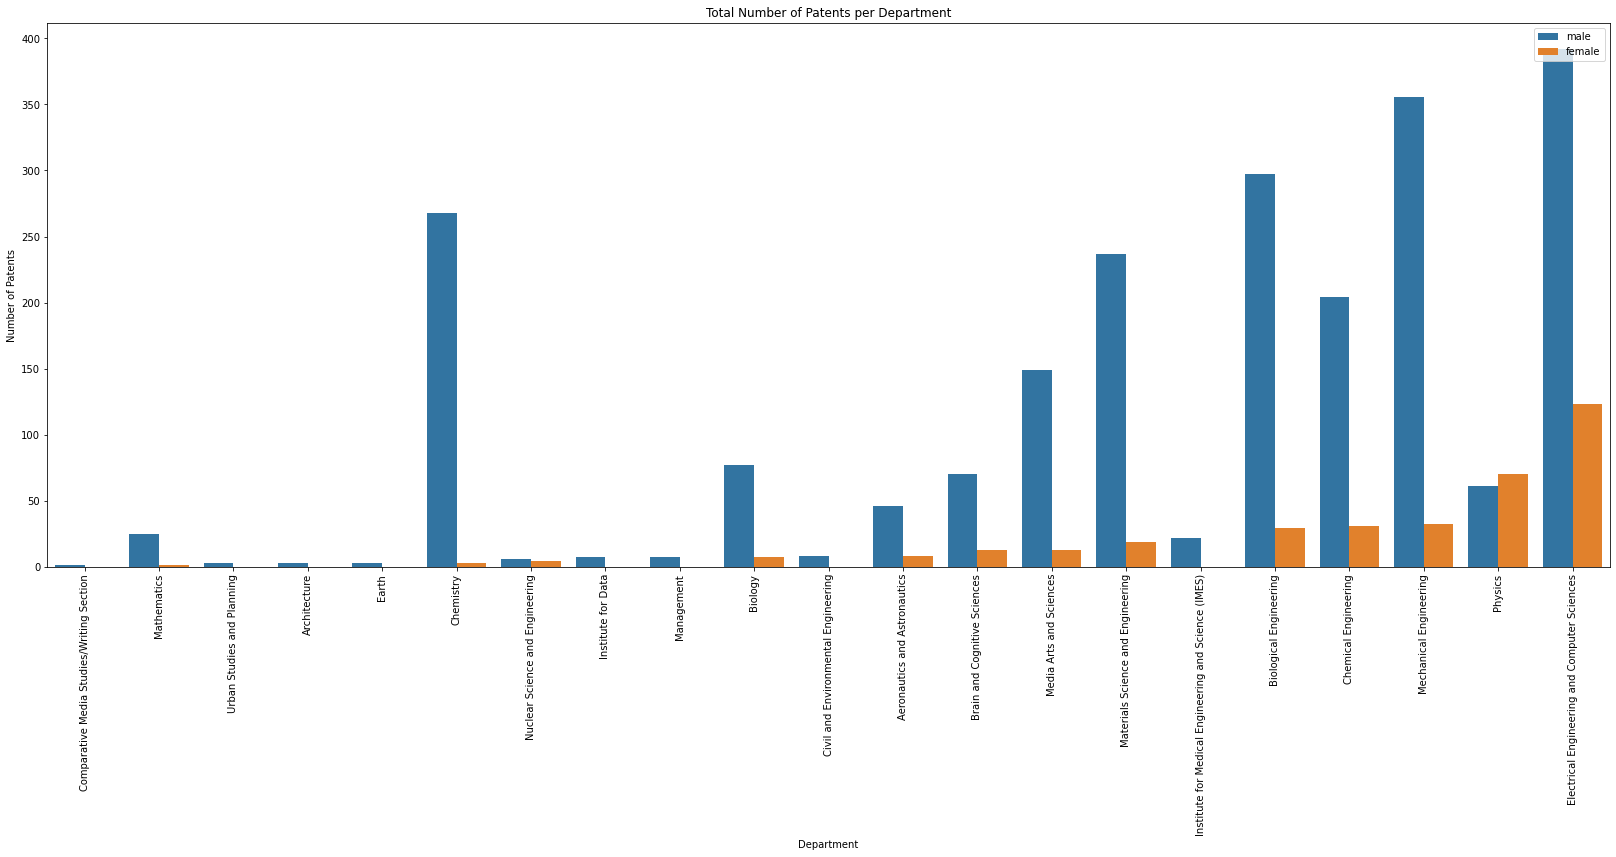

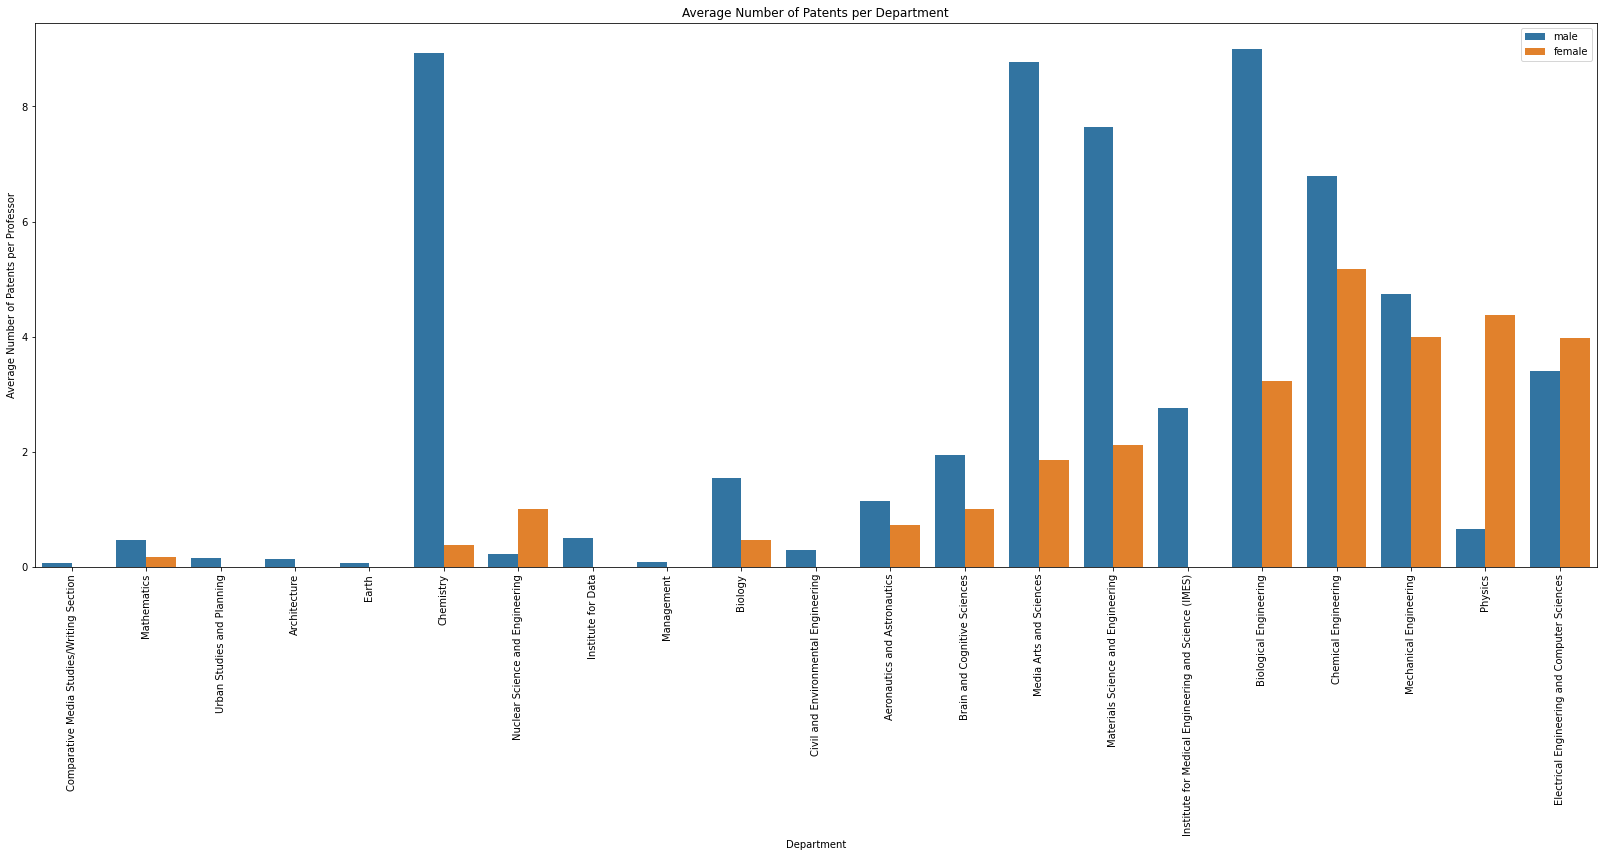

In [60]:
fig = plt.figure(figsize=(28, 10))
sns.barplot(x='Department', y='N_Patents', hue='Gender', data=n_patents_department.sort_values('N_Patents'))
plt.legend()
plt.xticks(rotation = 90)
plt.title('Total Number of Patents per Department')
plt.ylabel('Number of Patents')

fig = plt.figure(figsize=(28, 10))
sns.barplot(x='Department', y='N_Patents_Prof', hue='Gender', data=n_patents_department.sort_values('N_Patents'))
plt.legend()
plt.xticks(rotation = 90)
plt.title('Average Number of Patents per Department')
plt.ylabel('Average Number of Patents per Professor')

Several of the departments see female professors having an average number of patents matching or even higher than their male peers, notably the Physics and Nuclear Science and Engineering departments, which have female professors acquiring on average several times more patents than the male professors respectively. However, the large disparity occurs in most departments, with a number of departments having no patents for female professors.

Finally, we plot the total number of patents and fraction of total number of patents for each gender in each year to see if the disparity is changing over time.

Text(0, 0.5, 'Number of Patents')

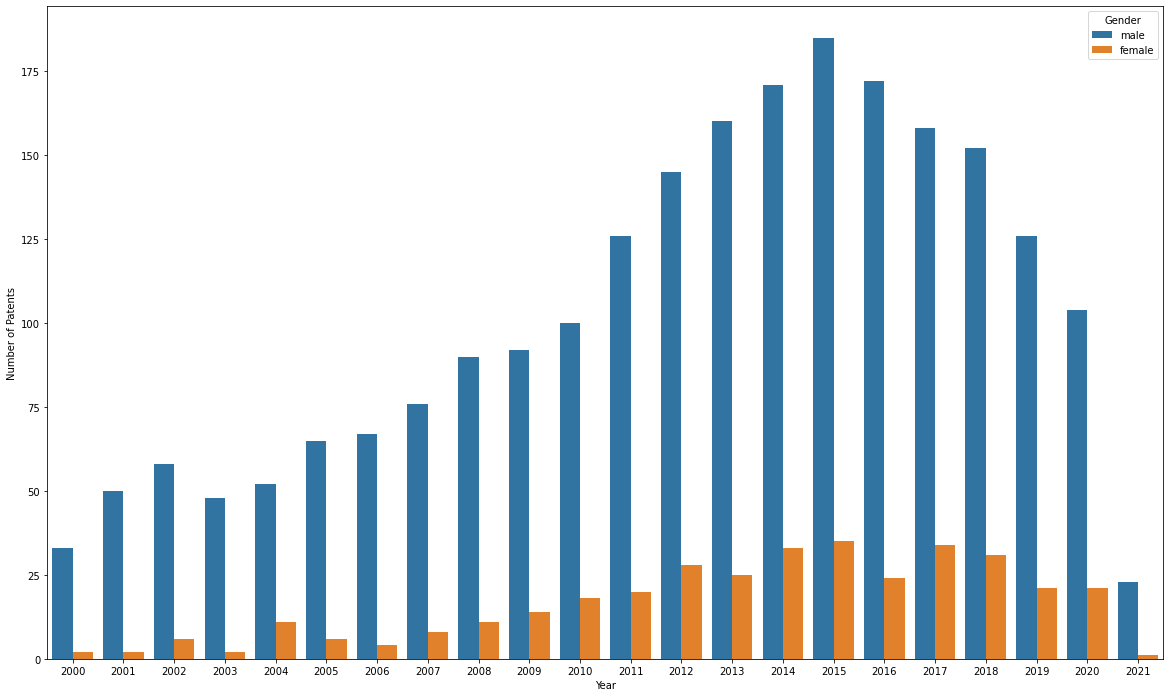

In [10]:
df_patents_nonan['Filing_Date'] = pd.to_datetime(df_patents_nonan['Filing_Date'])
patents_year = df_patents_nonan['Gender'].groupby(df_patents_nonan['Filing_Date'].dt.year).value_counts().to_frame('N_Patents').reset_index()
fig = plt.figure(figsize=(20, 12))
sns.barplot(x='Filing_Date', y='N_Patents', hue='Gender', data=patents_year)
plt.xlabel('Year')
plt.ylabel('Number of Patents')

Text(0, 0.5, 'Fraction of Total Number of Patents')

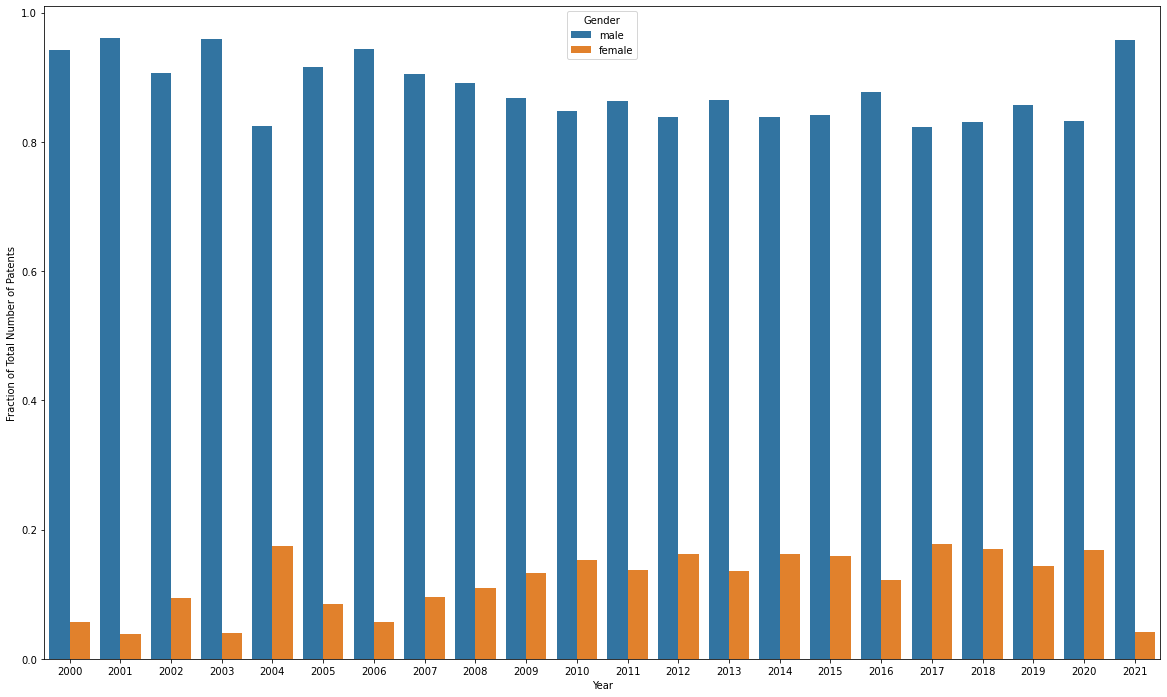

In [11]:
patents_year_norm = df_patents_nonan['Gender'].groupby(df_patents_nonan['Filing_Date'].dt.year).value_counts(normalize=True).to_frame('N_Patents').reset_index()
fig = plt.figure(figsize=(20, 12))
sns.barplot(x='Filing_Date', y='N_Patents', hue='Gender', data=patents_year_norm)
plt.xlabel('Year')
plt.ylabel('Fraction of Total Number of Patents')

Here we see the disparity steadily decreasing from 2000 to 2010 and remaining roughly constant through 2011 to 2020. We have yet to acquire the working years of each professor in MIT so we cannot calculate the average number of patents per professor for each gender in each year, which might shed more light on how the disparity in gender has shifted over the year. Associated year for articles, conference proceedings and more patents will be scraped and analyzed to get a more complete picture.

### Refine Project Scope, Limitations with Data and Potential Risks

We have had no updates on this topic since our last deliverable.